In [3]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from glob import glob
import random


IMG_PATH = "Task07_Pancreas/imagesTr/"
LBL_PATH = "Task07_Pancreas/labelsTr/"


In [4]:


class DataSet:

    def __init__(self, imgs, lbls=None):
        self.imgs = imgs
        self.lbls = lbls

    def get_length(self):
        return len(self.imgs)

    def show_image(self, i, j):
        plt.imshow(self.imgs[i, j])
        plt.title('RGB image')
        plt.show()


class BatchCreator:

    def __init__(self, patch_extractor, dataset, target_size):
        self.patch_extractor = patch_extractor
        self.target_size = target_size  # size of the output, can be useful when valid convolutions are used

        self.imgs = dataset.imgs
        self.lbls = dataset.lbls

        self.n = len(self.imgs)
        self.patch_size = self.patch_extractor.patch_size

    def create_image_batch(self, batch_size):
        '''
        returns a single augmented image (x) with corresponding labels (y)
        '''

        x_data = np.zeros((batch_size, *self.patch_extractor.patch_size))
        y_data = np.zeros((batch_size, *self.target_size))

        for i in range(0, batch_size):
            random_index = np.random.choice(len(self.imgs))  # pick random image
            img, lbl = self.imgs[random_index], self.lbls[random_index]  # get image and segmentation map
            patch_img, patch_lbl = self.patch_extractor.get_patch(img,
                                                                  lbl)  # when image size is equal to patch size, this line is useless...

            # crop labels based on target_size
            h, w, _ = patch_lbl.shape
            x_data[i, :, :, :] = patch_img
            y_data[i, :, :, :] = patch_lbl
            # ph = (self.patch_extractor.patch_size[0] - self.target_size[0]) // 2
            # pw = (self.patch_extractor.patch_size[1] - self.target_size[1]) // 2
            # x_data[i, :, :, :] = patch_img
            # y_data[i, :, :, 0] = 1 - patch_lbl[ph:ph + self.target_size[0], pw:pw + self.target_size[1]].squeeze()
            # y_data[i, :, :, 1] = patch_lbl[ph:ph + self.target_size[0], pw:pw + self.target_size[1]].squeeze()

        return (x_data.astype(np.float32), y_data.astype(np.float32))

    def get_image_generator(self, batch_size):
        '''returns a generator that will yield image-batches infinitely'''
        while True:
            yield self.create_image_batch(batch_size)


class PatchExtractor:

    def __init__(self, patch_size):
        self.patch_size = patch_size

    def get_patch(self, image, label):
        '''
        Get a patch of patch_size from input image, along with corresponding label map.
        This function works with image size >= patch_size, and pick random location of the patch inside the image.
        (Possibly) return a flipped version of the image and corresponding label.

        image: a numpy array representing the input image
        label: a numpy array representing the labels corresponding to input image
        '''

        # pick a random location
        dims = image.shape
        h = random.randint(0, dims[0] - self.patch_size[0])
        l = random.randint(0, dims[1] - self.patch_size[1])
        w = random.randint(0, dims[2] - self.patch_size[2])

        patch = image[h:h + self.patch_size[0], l:l + self.patch_size[1], w:w + self.patch_size[2]]
        target = label[h:h + self.patch_size[0], l:l + self.patch_size[1], w:w + self.patch_size[2]].reshape\
            (self.patch_size[0], self.patch_size[1], self.patch_size[2])

        patch_out = patch  # / 255.  # normalize image intensity to range [0., 1.]
        target_out = target

        return patch_out, target_out


(10, 128, 128, 3)


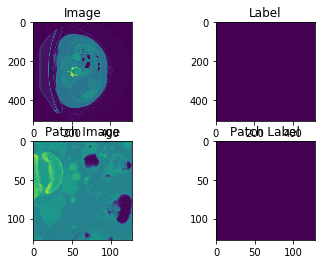

In [8]:

# # First images
files = "pancreas_*.nii.gz"
num_of_imgs = 1
img_files = glob(IMG_PATH + files)[:num_of_imgs]
imgs = [nib.load(file) for file in img_files]
imgs = [img.get_fdata() for img in imgs]

lbl_files = glob(LBL_PATH + files)[:num_of_imgs]
lbls = [nib.load(file) for file in lbl_files]
lbls = [lbl.get_fdata() for lbl in lbls]

train_data = DataSet(np.array(imgs), np.array(lbls))

patch_length = 128
patch_size = (patch_length, patch_length, 3)
patchExtractor = PatchExtractor(patch_size)
target_size = (patch_length, patch_length, 3)
batch_size = 10

batchCreator = BatchCreator(patchExtractor, train_data, target_size)

gen = batchCreator.get_image_generator(batch_size)

example = gen.__next__()
print(example[0].shape)

plt.subplot(221)
plt.title("Image")
plt.imshow(imgs[0][:, :, 20])

plt.subplot(222)
plt.title("Label")
plt.imshow(lbls[0][:, :, 20])

plt.subplot(223)
plt.title("Patch Image")
plt.imshow(example[0][0, :, :, 0])

plt.subplot(224)
plt.title("Patch Label")
plt.imshow(example[1][0, :, :, 0])
plt.show()
